<a href="https://colab.research.google.com/github/BlancaCC/Computer-vision/blob/main/P3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica 3 
Autor: Blanca Cano Camarero 




# Apartado 1: BaseNet en CIFAR1000

Convolucional, es decir, Conv2D.(normal y atrous)
Agrupación: Local y Global MaxPooling2D and AveragePooling2D().
Densa (lineal), es decir, Fully connected
Activaciones no lineales, p.e. relu, leaky relu, etc
Aplanar, es decir, Flatten.
Normalización del batch, p.e. BatchNormalization.
Regularización: p.e. Dropout



(12500, 25) (2500, 25)


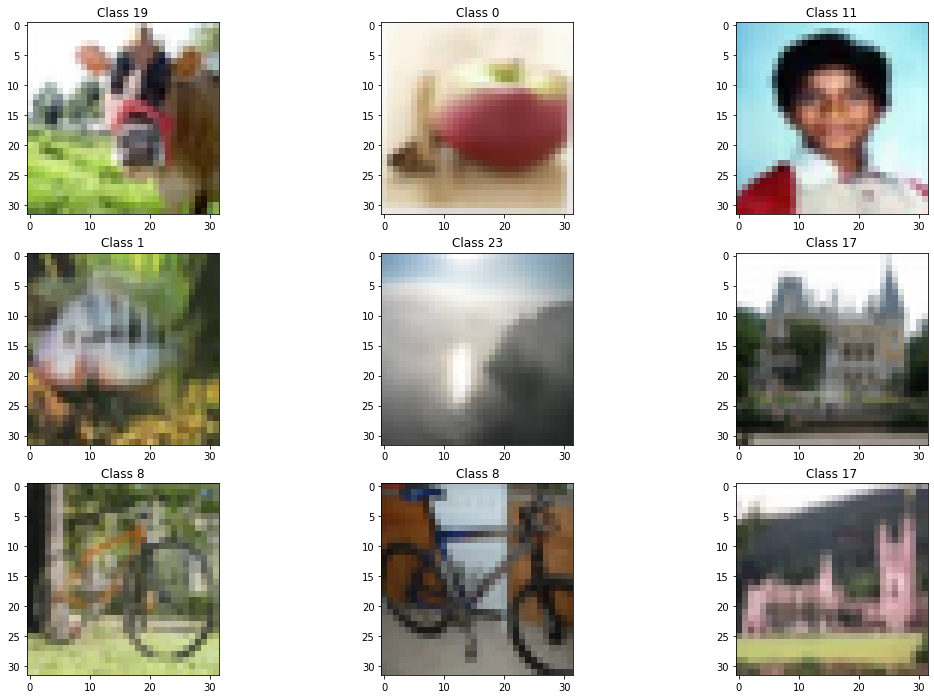

In [2]:
#Importamos los paquetes necesarios para toda la práctica
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, Flatten, UpSampling2D
# Importar el optimizador a usar
from tensorflow.python.keras.optimizers import *
# Importar el conjunto de datos
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator

# A partir de aquí has el final de la celda seguimos el esquema de la parte 1 y 2

#########################################################################
######## FUNCIÓN PARA CARGAR Y MODIFICAR EL CONJUNTO DE DATOS ###########
#########################################################################

# A esta función sólo se le llama una vez. Devuelve 4 vectores conteniendo,
# por este orden, las imágenes de entrenamiento, las clases de las imágenes
# de entrenamiento, las imágenes del conjunto de test y las clases del
# conjunto de test.

def cargarImagenes():
  # Cargamos Cifar100. Cada imagen tiene tamaño (32, 32, 3).
  # Nos vamos a quedar con las imágenes de 25 de las clases.
  
  (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train /= 255
  x_test /= 255
  
  train_idx = np.isin(y_train, np.arange(25))
  train_idx = np.reshape(train_idx,-1)
  x_train = x_train[train_idx]
  y_train = y_train[train_idx]
  
  test_idx = np.isin(y_test, np.arange(25))
  test_idx = np.reshape(test_idx, -1)
  x_test = x_test[test_idx]
  y_test = y_test[test_idx]
  
  # Transformamos los vectores de clases en matrices. Cada componente se convierte en un vector
  # de ceros con un uno en la componente correspondiente a la clase a la que pertenece la imagen.
  # Este paso es necesario para la clasificación multiclase en keras.
  y_train = np_utils.to_categorical(y_train, 25)
  y_test = np_utils.to_categorical(y_test, 25)
  
  return x_train, y_train, x_test, y_test

#########################################################################
######## FUNCIÓN PARA OBTENER EL ACCURACY DEL CONJUNTO DE TEST ##########
#########################################################################

# Esta función devuelve el accuracy de un modelo, definido como el 
# porcentaje de etiquetas bien predichas frente al total de etiquetas.
# Como parámetros es necesario pasarle el vector de etiquetas verdaderas
# y el vector de etiquetas predichas, en el formato de keras (matrices
# donde cada etiqueta ocupa una fila, con un 1 en la posición de la clase
# a la que pertenece y 0 en las demás).

def calcularAccuracy(labels, preds):
  labels = np.argmax(labels, axis = 1)
  preds = np.argmax(preds, axis = 1)
  
  accuracy = sum(labels == preds)/len(labels)
  
  return accuracy



#########################################################################
## FUNCIÓN PARA PINTAR LA PÉRDIDA Y EL ACCURACY EN TRAIN Y VALIDACIÓN ###
#########################################################################

# Esta función pinta dos gráficas, una con la evolución de la función
# de pérdida en el conjunto de train y en el de validación, y otra
# con la evolución del accuracy en el conjunto de train y en el de
# validación. Es necesario pasarle como parámetro el historial
# del entrenamiento del modelo (lo que devuelven las funciones
# fit() y fit_generator()).

def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['acc']
  val_acc = hist.history['val_acc']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()
  
# Cargamos imágenes y vemos su tamaño   
x_train, y_train, x_test, y_test =  cargarImagenes()
print('Comprobamos que el tamaño de test y entrenamiento son los pedidos en el enunciado: ')
print('Shape de entrenamiento: ', y_train.shape, 'Shape de test: ', y_test.shape)

#VISUALIZAMOS ALGUNAS DE LAS IMÁGENES DEL DATASET
number_images_per_row = 3
result = np.where(y_train == 1)
fig = plt.figure()
for i in range(number_images_per_row*number_images_per_row):
  label = 'Class {}'.format(result[1][i])
  plt.subplot(number_images_per_row,number_images_per_row,i+1).set_title(label)
  plt.imshow(x_train[i].squeeze(), cmap='gray',vmin=0,vmax=1)

fig.set_size_inches(np.array(fig.get_size_inches()) * number_images_per_row)
plt.show()



# Ejercicio 1 
## Definición del modelo BASENET
Para este ejercicio trabajaremos con el modelo BaseNet que consta de dos módulos convolucionales, la descripción precisa es la siguiente: 


|Layer | Layer type | tamaño kernel | input / output dim | input/output channels |
|:-: | :-: | :-:  | :-:  | :-: |
|1 | conv2d  | 5 | 32/28 | 3 / 6 |
  

## Descripción teórica y de uso en keras de cada capa    

### Clase `Sequential`  

Documentación:  

- Documentación oficial de keras consultada a día 18-12-2021: https://keras.io/api/models/sequential/  

Necesitaremos primero definir una clase `Sequential` en la que poder alamcenar la cola de capas que se deberán de ir aplicando. 

`tf.keras.Sequential(layers=None, name=None)`  

### Convolución 2D  

Documentación: 
- Documentación oficial de keras consultada a día 18-12-2021: https://keras.io/api/layers/convolution_layers/convolution2d/  

Descripcion:  
Esta capa crea un kernel de convolución que se aplica a la capa de entrada produciendo un tensor de salida.    

Los argumentos soportados por keras son los siguientes: 

```
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding="valid",
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True, 
    kernel_initializer="glorot_uniform",
    bias_initializer="zeros",
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)

```

Parámetros a tener en cuenta: 
- Si `use_bias = True` un vector de sesgo es añadido, como en nuestro caso no se especifica nada lo dejaremos en blanco.  
- Puede añadirse una función de activación que se aplicará a la salida gracias a `activation`. 
- Si es la primera capa en el modelo debe inicializarse `input_shape` con una tupla que recoja los tamaños siempre que ésta no tenga la variable `size` (como es nuestro caso).   
- `data_format` será el parámetro que convenga si la dimensión de los canales va al principio o al final, los parámetros que admite son los strings: `'channels_first'` o `'channels_last'`. Puede consultase y modificar con: `tf.keras.backend.image_data_format()`.  **En nuestro caso usaremos convenio `channels_last`* por seguir la notación de teoría.**

Por lo que nuestro input channel será del tipo `channels_last` y concretamente `(32,32,3)` ya que las imágenes son de tamaño 32x32 y además están a color. 

Comentaremos el significado de más parámetros conforme los vayamos necesitando. 

# A completar
# 1.- Incluir  import del tipo de modelo y capas a usar
# 2.- definir model e incluir las capas en él

In [4]:
# necesario introducir el tamaño inicial 
# Calculamos input shape 
# las imágenes son de 32x32x3 según la documentación de prácticas, luego 
input_shape = (32,32,3) 



# Descripción del modelo 
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='softmax'))
# AQUI ACABA LA DESCRIPCION DEL MODELO

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
Total params: 19,392
Trainable params: 19,392
Non-trainable params: 0
_________________________________________________________________
